In [2]:
#@title Download dataset of personal attacks from the [wiki detox datasets](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release).

import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634'
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637'

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')
print(f"Successfully downloaded {len(comments)} comments and {len(annotations)} annotations.")
print("[TODO]: explore comments and annotations.")

Successfully downloaded 115864 comments and 1365217 annotations.
[TODO]: explore comments and annotations.


In [3]:
#@title Build a labeled dataset of personal attacks, from annotations.
# labels a comment as an attack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
# join labels and comments
comments['attack'] = labels
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
print(f"Built a labeled dataset of attacks, based on majority annotations. Sample of attacks:")
comments.query('attack')['comment'].head()

Built a labeled dataset of attacks, based on majority annotations. Sample of attacks:


rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      ____ fuck off you little asshole. If you wan...
4632658         i have a dick, its bigger than yours! hahaha
6545332      == renault ==  you sad little bpy for drivin...
6545351      == renault ==  you sad little bo for driving...
Name: comment, dtype: object

In [4]:
#@title Train a simple text classifier.

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Trained a binary classifier, with test set ROC AUC: %.3f' %auc)
print("[TODO]: What do these things mean? ngram_range, norm, confusion matrix, AUC")

Trained a binary classifier, with test set ROC AUC: 0.957
[TODO]: What do these things mean? ngram_range, norm, confusion matrix, AUC


In [5]:
#@title Testing the classifier on some new text.
nice_comment = "This is a good review!" #@param {type: "raw"}
nasty_comment = "You are stupid and an idiot!" #@param {type: "raw"}
clf.predict([nice_comment, nasty_comment])

array([False,  True])

In [17]:
#@title Download full unlabeled user-talk and article-talk 2004 corpus.
import os
import re
from scipy.stats import bernoulli
import seaborn as sns
import matplotlib.pyplot as plt

# download and untar data
USER_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/6982061'
ARTICLE_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/7038050'

download_file(USER_TALK_CORPUS_2004_URL, 'comments_user_2004.tar.gz')
download_file(ARTICLE_TALK_CORPUS_2004_URL,  'comments_article_2004.tar.gz')

os.system('tar -xzf comments_user_2004.tar.gz')
os.system('tar -xzf comments_article_2004.tar.gz')

# helper for collecting a sample of comments for a given ns and year from
def load_no_bot_no_admin(ns, year, prob = 0.1):
    dfs = []
    data_dir = "comments_%s_%d" % (ns, year)
    for _, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.match("chunk_\d*.tsv", filename):
                df = pd.read_csv(os.path.join(data_dir, filename), sep = "\t")
                df['include'] = bernoulli.rvs(prob, size=df.shape[0])
                df = df.query("bot == 0 and admin == 0 and include == 1")
                dfs.append(df)
    sample = pd.concat(dfs)
    sample['ns'] = ns
    sample['year'] = year
    return sample

# collect a random sample of comments from 2004 for each namespace
corpus_user = load_no_bot_no_admin('user', 2004)
corpus_article = load_no_bot_no_admin('article', 2004)
corpus = pd.concat([corpus_user, corpus_article])

print("Downloaded random sample of comments from each corpus: user and article")
print("[TODO]: Explore the data")

Downloaded random sample of comments from each corpus: user and article
[TODO]: Explore the data


In [25]:
#@title Use our classifier to label these two datasets.
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
corpus['attack'] = clf.predict_proba(corpus['comment'])[:,1] > 0.425 # why this threshold?
corpus.query("attack")["comment"].head()

1361    "**You, dude. You're the guy upset at vandals ...
3025       Please stop supporting  for adminship. He m...
6833                  You're welcome! You deserve it.    
8358         "  You're welcome, and enjoy your break.   "
8524                                   == you'r a dork ==
Name: comment, dtype: object

In [32]:
corpus.query("attack")["comment"].iloc[15]

'"  ==Crazy Shit== *People have bent over backwards to accomodate you, mostly out of a pure concern for fairness and justice. You have eroded all the good will left in my body. Any more crap out of you, and I will ""take steps"". Better listen up good, because I\'m one the oldest ""old hands"" around here and I know how to work the system. Don\'t get me riled up against you, or I will force you out!! (A word to the wise is sufficient.) Uncle Ed   **No matter how old you are, you don\'t have the authority to force anyone out unilaterally. This rhetoric just once again shows how unfit you are for sysophood. Wik   **Well; who would have thought we could ever; agree? Ed Poor is totally unfit. "'

Text(0.5, 0, 'Dataset type')

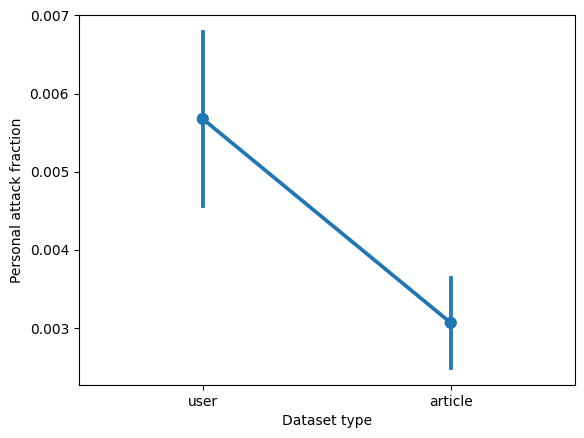

In [33]:
#@title Which corpus has higher prevalence of personal attacks - user or article?
sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Personal attack fraction")
plt.xlabel("Dataset type")

# Assignments

1. Use pre-trained bert_classifier for personal attacks ([keras_nlp](https://keras.io/api/keras_nlp/models/bert/bert_classifier/)).
2. Explore the word embeddings of top attack words.

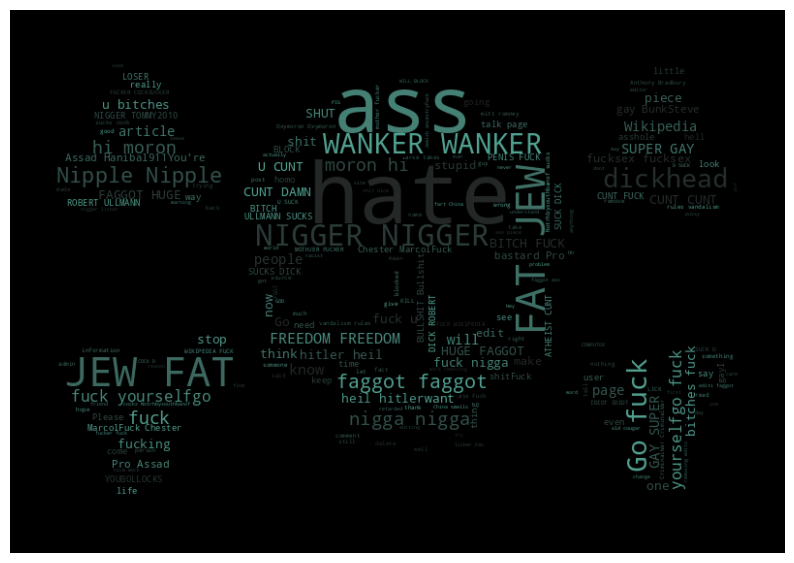

In [12]:
#@title Visualizing a word-cloud of top attack words.
from wordcloud import WordCloud
import requests
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

image_url = 'https://thumbs.dreamstime.com/b/black-pirate-skull-crossbones-danger-symbol-warning-poison-dangerous-place-closeup-vector-flat-icon-isolated-white-188336057.jpg'
response = requests.get(image_url)
skull_mask = np.array(Image.open(BytesIO(response.content)))
palette = sns.color_palette("dark:#5A9_r", as_cmap=True)
wordcloud = WordCloud(mask=skull_mask, background_color='black', colormap=palette)
wordcloud.generate(' '.join(train_comments.query("attack")['comment']))

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

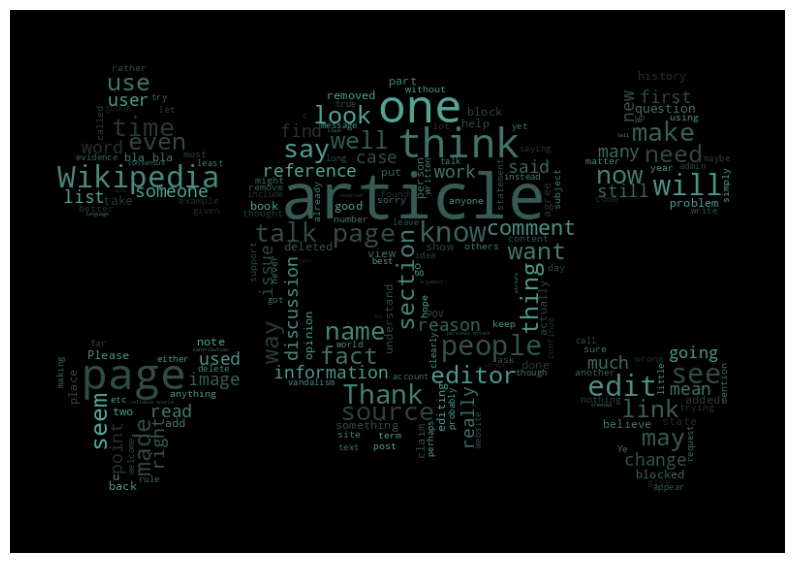

In [43]:
#@title Visualizing a word-cloud of non-attack words.

wordcloud = WordCloud(mask=skull_mask, background_color='black', colormap=palette)
wordcloud.generate(' '.join(train_comments.query("~attack")['comment']))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [50]:
#@title Representing out-of-vocabulary (OOV) words with morphology - FastText.
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html
from gensim.models import FastText
# Also explore: from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import re

def tokenize(comment):
  comment = re.sub('[^0-9a-zA-Z]+', ' ', comment)
  return comment.split(' ')

tokenized_train_comments = [
    tokenize(comment) for comment in train_comments['comment']]
tokenized_test_comments = [
    tokenize(comment) for comment in test_comments['comment']]
word_vector_model = FastText()
word_vector_model.build_vocab(corpus_iterable=tokenized_train_comments)
word_vector_model.train(
    corpus_iterable=tokenized_train_comments,
    total_examples=word_vector_model.corpus_count,
    total_words=word_vector_model.corpus_total_words,
    epochs=5)

def get_embedding(model, comment):
    embeddings = [model.wv[word] for word in comment if word in model.wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    return []

train_embeddings = pd.DataFrame([
      get_embedding(word_vector_model, comment) for comment in tokenized_train_comments
    ])
test_embeddings = pd.DataFrame([
      get_embedding(word_vector_model, comment) for comment in tokenized_test_comments
    ])
word_vector_model.wv.most_similar("mexican", topn=30)

[('canadian', 0.922435462474823),
 ('Mexican', 0.9213892817497253),
 ('Rican', 0.9152387976646423),
 ('african', 0.9117598533630371),
 ('anglican', 0.9095998406410217),
 ('Etruscan', 0.8972310423851013),
 ('dominican', 0.8953298926353455),
 ('Anglican', 0.8914424180984497),
 ('Vatican', 0.8850505352020264),
 ('Moroccan', 0.8839904069900513),
 ('Dominican', 0.8821433186531067),
 ('Jamaican', 0.8794663548469543),
 ('scan', 0.8683005571365356),
 ('american', 0.8681765794754028),
 ('diwan', 0.8593645691871643),
 ('African', 0.858230471611023),
 ('Vulcan', 0.8557833433151245),
 ('Duncan', 0.8555055856704712),
 ('magician', 0.842637836933136),
 ('juan', 0.8378971815109253),
 ('Wiccan', 0.8377812504768372),
 ('hganesan', 0.8310405611991882),
 ('Yucatan', 0.8308194279670715),
 ('iran', 0.8238524794578552),
 ('moroccan', 0.823381781578064),
 ('caucasian', 0.8229647278785706),
 ('SarekOfVulcan', 0.816735565662384),
 ('aryan', 0.8165539503097534),
 ('American', 0.8142074346542358),
 ('fran', 0.81

In [40]:
#@title Explore word analogies with pre-trained GLOVE embeddings.

import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")
result = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
result

[==================================================] 100.0% 128.1/128.1MB downloaded


[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.631171703338623),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [49]:
word_vectors.most_similar("fat", topn=30)

[('calories', 0.7466872334480286),
 ('cholesterol', 0.7134947180747986),
 ('carbohydrates', 0.6913952231407166),
 ('grams', 0.6906240582466125),
 ('saturated', 0.6768878698348999),
 ('sodium', 0.6713735461235046),
 ('protein', 0.6698625683784485),
 ('carbohydrate', 0.6625745892524719),
 ('milk', 0.6385780572891235),
 ('fats', 0.632804811000824),
 ('milligrams', 0.6214337348937988),
 ('chicken', 0.6135520935058594),
 ('diet', 0.6073150634765625),
 ('meat', 0.603980302810669),
 ('fatty', 0.602017879486084),
 ('sugar', 0.5874170064926147),
 ('fiber', 0.5830346345901489),
 ('gram', 0.5785846710205078),
 ('soft', 0.5776798129081726),
 ('pork', 0.5770535469055176),
 ('eat', 0.5765317678451538),
 ('dietary', 0.5731467604637146),
 ('calorie', 0.5719451308250427),
 ('diets', 0.5719350576400757),
 ('eating', 0.570774495601654),
 ('butter', 0.5666366815567017),
 ('mg', 0.5532779693603516),
 ('cream', 0.5490147471427917),
 ('vegetable', 0.5473135113716125),
 ('lean', 0.5461708903312683)]

In [53]:
#@title Naive classifier based on learned FastText embeddings (not modeling the sequence).
model = LogisticRegression(max_iter=1000)
model.fit(train_embeddings, train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], model.predict_proba(test_embeddings)[:, 1])
print('Trained a binary classifier, with test set ROC AUC: %.3f' %auc)

Trained a binary classifier, with test set ROC AUC: 0.923


In [70]:
#@title Naive classifier based on pre-trained GLOVE embeddings (not modeling the sequence).
def get_embedding(model, comment):
    embeddings = [model[word] for word in comment if word in model]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    return np.array([0] * 100)

train_embeddings = pd.DataFrame([
      get_embedding(word_vectors, comment) for comment in tokenized_train_comments
    ])
test_embeddings = pd.DataFrame([
      get_embedding(word_vectors, comment) for comment in tokenized_test_comments
    ])

model = LogisticRegression(max_iter=1000)
model.fit(train_embeddings, train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], model.predict_proba(test_embeddings)[:, 1])
print('Trained a binary classifier, with test set ROC AUC: %.3f' %auc)

Trained a binary classifier, with test set ROC AUC: 0.899


# Assignments #2

  * Use pre-trained transformer model to train the classifier with pre-trained word embeddings.